<a href="https://colab.research.google.com/github/Javsk891/Nasdaq100-Predictions/blob/main/Nasdaq100Predict.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import pandas as pd

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

In [2]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')
plt.style.use("fivethirtyeight")
%matplotlib inline

from pandas_datareader.data import DataReader
from datetime import datetime
from math import sqrt
from math import sqrt
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
import warnings
warnings.filterwarnings('ignore')

In [3]:
try:
    from keras.models import Sequential
    from keras.layers import Dense, LSTM
    import tensorflow as tf
except:
    !pip install --upgrade tensorflow
    !pip install keras
    !pip install --ignore-installed --upgrade tensorflow-gpu
    !pip install wrapt==1.11.1
    from keras.models import Sequential
    from keras.layers import Dense, LSTM
    import tensorflow as tf

In [9]:
from keras.models import Sequential
from keras.layers import Dense, LSTM
import tensorflow as tf
import yfinance as yf

In [16]:
import yfinance as yf
from datetime import datetime

def collect_data(Symbol, start_date):
    """
    Collects stock data using yfinance.

    Args:
        Symbol (str): The stock symbol (e.g., 'AAPL').
        start_date (str): The start date in 'YYYY-MM-DD' format.

    Returns:
        pandas.DataFrame: The stock data.
    """
    # Create a yfinance ticker object
    ticker = yf.Ticker(Symbol)

    # Download historical data
    stock_data = ticker.history(start=start_date, end=datetime.now())

    return stock_data

# Test the function
df = collect_data('^NDX', '2021-01-01')

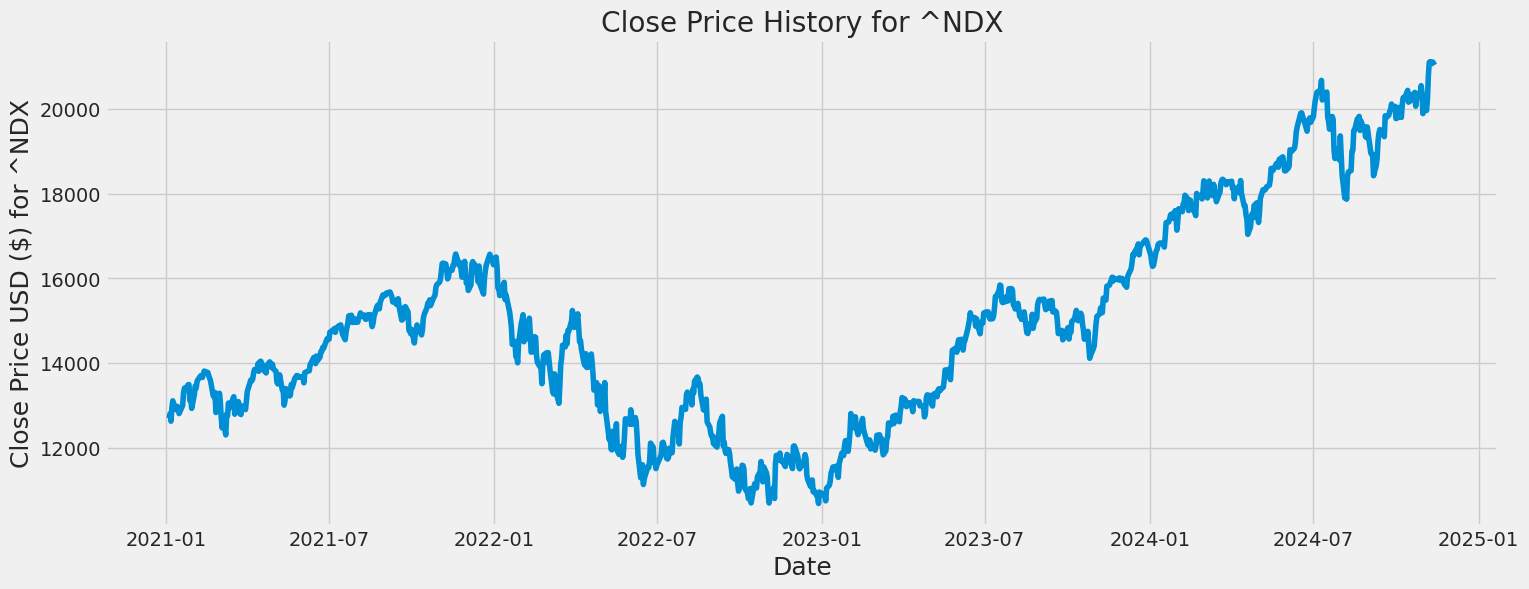

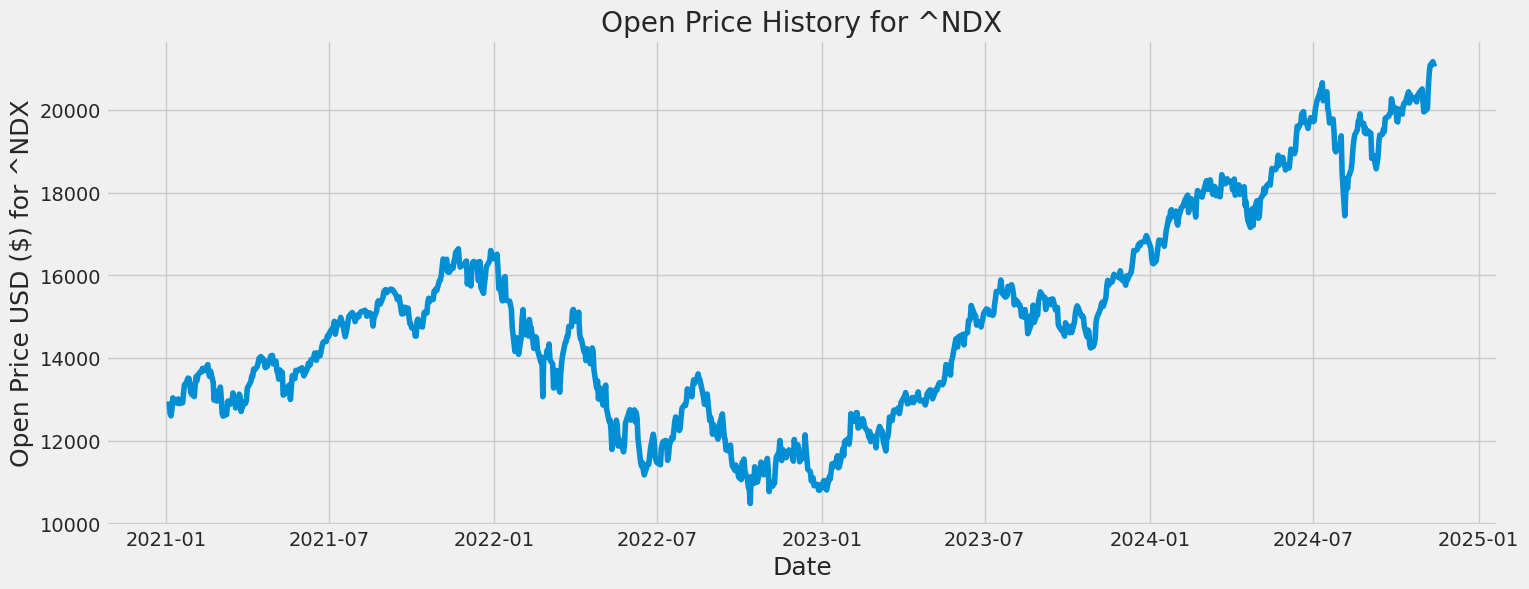

In [17]:
def plot_close_val(data_frame, column, stock):
    plt.figure(figsize=(16,6))
    plt.title(column + ' Price History for ' + stock )
    plt.plot(data_frame[column])
    plt.xlabel('Date', fontsize=18)
    plt.ylabel(column + ' Price USD ($) for ' + stock, fontsize=18)
    plt.show()

#Test the function
plot_close_val(df, 'Close', '^NDX')
plot_close_val(df, 'Open',  '^NDX')

In [18]:
def build_training_dataset(input_ds):
    input_ds.reset_index()
    data = input_ds.filter(items=['Close'])
    dataset = data.values
    training_data_len = int(np.ceil( len(dataset) * .95 ))
    return data, dataset, training_data_len

training_data_df, training_dataset_np, training_data_len = build_training_dataset(df)
dataset=training_dataset_np
data=training_data_df

In [19]:
from sklearn.preprocessing import MinMaxScaler
def scale_the_data(dataset):
    scaler = MinMaxScaler(feature_range=(0,1))
    scaled_data = scaler.fit_transform(dataset)
    return scaler, scaled_data

scaler, scaled_data = scale_the_data(training_dataset_np)

In [20]:
def split_train_dataset(training_data_len):
    train_data = scaled_data[0:int(training_data_len), :]
    x_train = []
    y_train = []
    for i in range(60, len(train_data)):
        x_train.append(train_data[i-60:i, 0])
        y_train.append(train_data[i, 0])
        if i<= 61:
            print('.')

    x_train, y_train = np.array(x_train), np.array(y_train)

    x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))

    return x_train, y_train

x_train,y_train = split_train_dataset(training_data_len)

.
.


In [21]:
def build_lstm_model(x_train,y_train):
    model = Sequential()
    model.add(LSTM(128, return_sequences=True, input_shape= (x_train.shape[1], 1)))
    model.add(LSTM(64, return_sequences=False))
    model.add(Dense(25))
    model.add(Dense(1))

    model.compile(optimizer='adam', loss='mean_squared_error')
    model.fit(x_train, y_train, batch_size=1, epochs=1)
    return model

lstm_model = build_lstm_model(x_train,y_train)

865/865 ━━━━━━━━━━━━━━━━━━━━ 73s 70ms/step - loss: 0.0104


In [24]:
def create_testing_data_set(model, scaler, training_data_len,test_data_len):
    test_data = scaled_data[training_data_len - test_data_len: , :]
    x_test = []
    y_test = dataset[training_data_len:, :]
    for i in range(test_data_len, len(test_data)):
        x_test.append(test_data[i-test_data_len:i, 0])

    x_test = np.array(x_test)

    x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1 ))

    predictions = model.predict(x_test)
    predictions = scaler.inverse_transform(predictions)

    rmse = np.sqrt(np.mean(((predictions - y_test) ** 2)))
    rmse
    return (x_test, y_test, predictions, rmse) # Remove the duplicated code block after this line

TEST_DATA_LENGTH = 100
x_test,y_test, predictions, rmse = create_testing_data_set(lstm_model,scaler,training_data_len, TEST_DATA_LENGTH)

2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 300ms/step


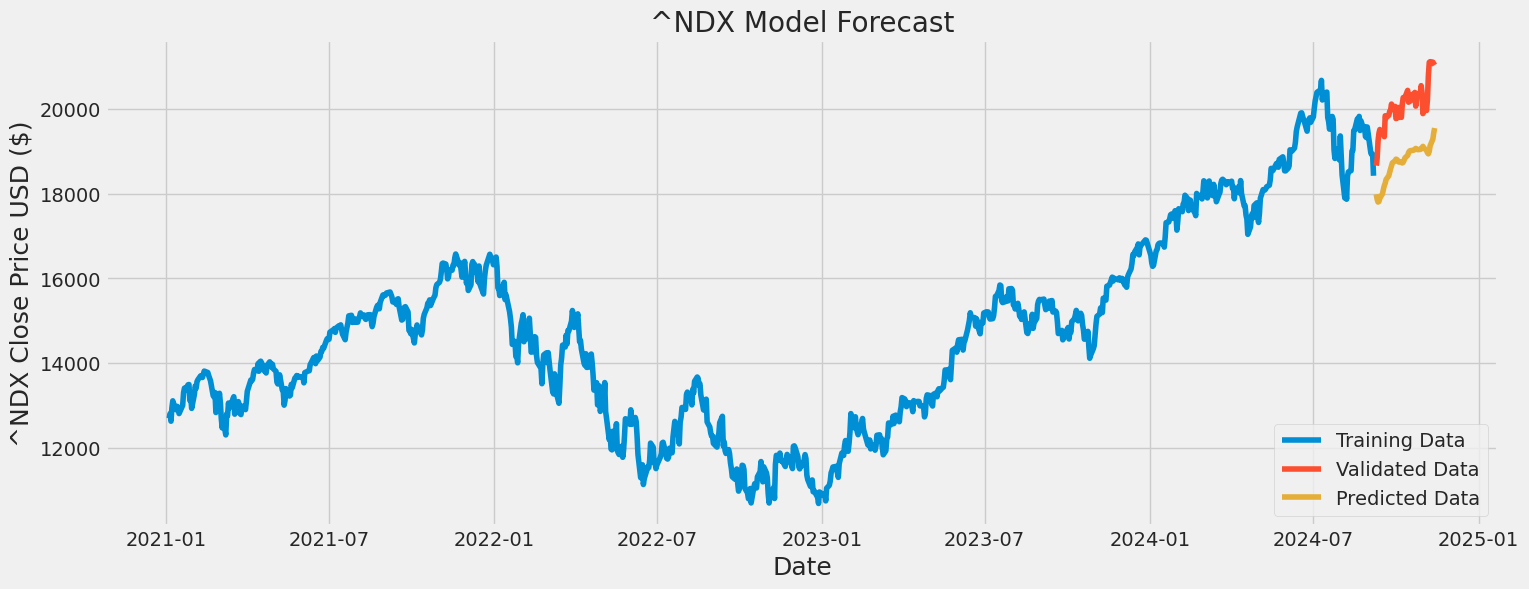

In [25]:
def plot_predictions(stock, data,training_data_len):
    train = data[:training_data_len]
    valid = data[training_data_len:]
    valid['Predictions'] = predictions
    plt.figure(figsize=(16,6))
    title = stock + ' Model Forecast'
    ylabel = stock + ' Close Price USD ($)'
    plt.title(title)
    plt.xlabel('Date', fontsize=18)
    plt.ylabel(ylabel, fontsize=18)
    plt.plot(train['Close'])
    plt.plot(valid[['Close', 'Predictions']])
    plt.legend(['Training Data', 'Validated Data', 'Predicted Data'], loc='lower right')
    plt.show()
    return valid

valid = plot_predictions('^NDX',data,training_data_len)

In [26]:
valid

,Close,Predictions
Date,,
2024-09-09 00:00:00-04:00,18660.779297,17984.703125
2024-09-10 00:00:00-04:00,18829.140625,17869.216797
2024-09-11 00:00:00-04:00,19237.300781,17800.654297
2024-09-12 00:00:00-04:00,19423.070312,17813.298828
2024-09-13 00:00:00-04:00,19514.589844,17888.775391
2024-09-16 00:00:00-04:00,19423.060547,17998.703125
2024-09-17 00:00:00-04:00,19432.400391,18101.960938
2024-09-18 00:00:00-04:00,19344.490234,18189.164062
2024-09-19 00:00:00-04:00,19839.830078,18245.576172


Let us evaluate for all of NASDAQ


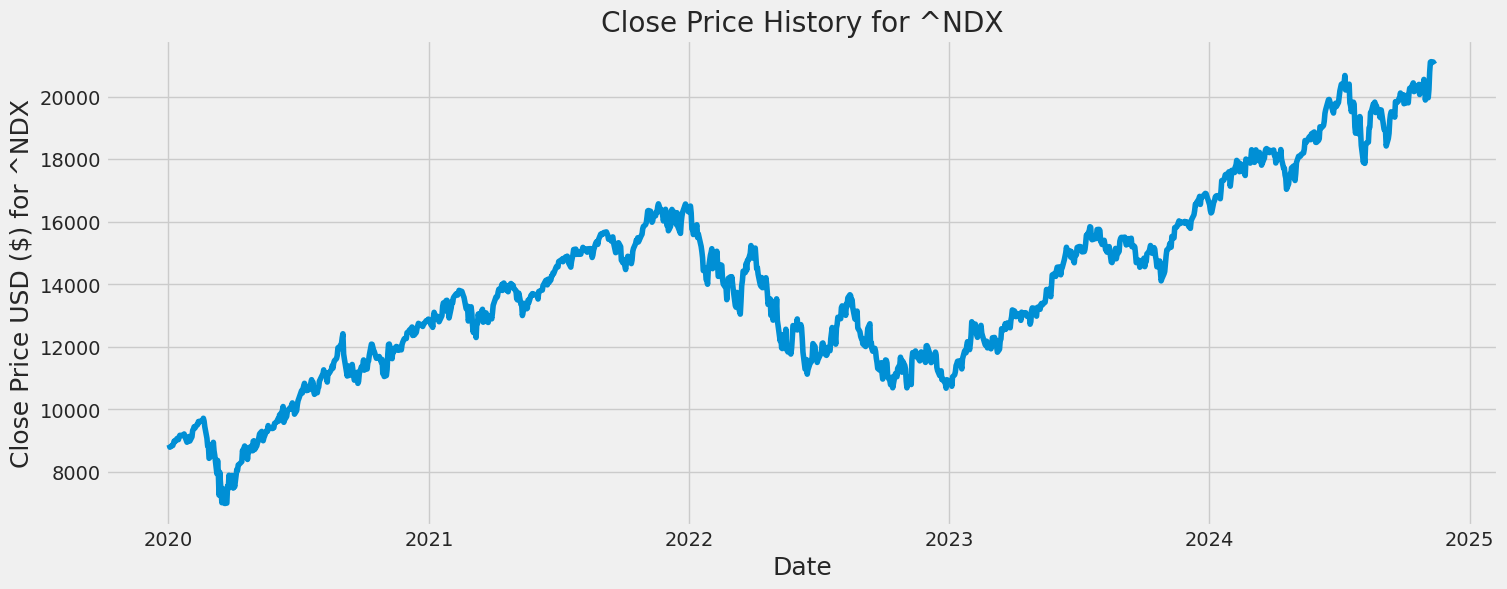

.
.
1105/1105 ━━━━━━━━━━━━━━━━━━━━ 71s 62ms/step - loss: 0.0044
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 343ms/step


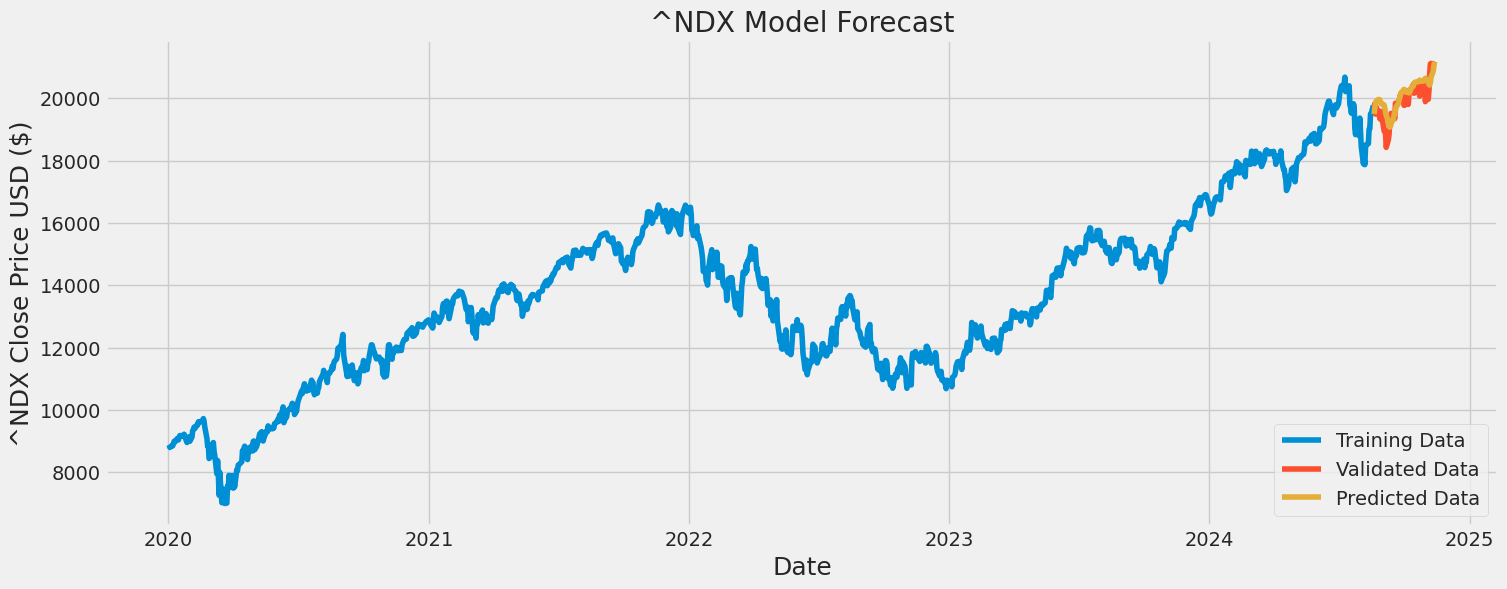

Test RMSE: 377.992
{'^NDX': 377.9917824510645}


In [27]:
stock_list = ['^NDX']
Symbols = ['^NDX'
]
TEST_DATA_LENGTH = 111
start_date = '2020-01-01'
error_scores = {}
print("Let us evaluate for all of NASDAQ")
for stock in Symbols:
    df = collect_data(stock,start_date) #Collect the data
    plot_close_val(df, 'Close', stock) # Plot the Closing Price
    #plot_close_val(df, 'Open', stock) # Plot the Opening Price
    #print(df.head()) # Print Dataframe check
    training_data_df, training_dataset_np, training_data_len = build_training_dataset(df) #Build the Training Dataset
    dataset=training_dataset_np
    data=training_data_df
    scaler, scaled_data = scale_the_data(training_dataset_np) #Scale the data
    x_train,y_train = split_train_dataset(training_data_len) #split the data
    lstm_model = build_lstm_model(x_train,y_train) #build the LSTM model
    x_test,y_test, predictions, rmse = create_testing_data_set(lstm_model,scaler,training_data_len, TEST_DATA_LENGTH ) #create testing dataset and predictions
    valid = plot_predictions(stock,data,training_data_len) #plot predictions
    valid   # Show the valid and predicted prices
    rmse = sqrt(mean_squared_error(valid['Close'], valid['Predictions']))
    print('Test RMSE: %.3f' % (rmse))
    #error_scores.append(rmse)
    error_scores[stock] = rmse

print(error_scores)